# Experimenting with Package Functions

IN PROGRESS

## Initial simulated LC generation with MOSFIT

In [2]:
from survey_agnostic_sn_vae.data_generation.mosfit2 import *
# from ..survey_agnostic_sn_vae.data_generation.objects import *
import os
OUTPUT_PATH = os.getcwd()
print(OUTPUT_PATH)
os.makedirs(OUTPUT_PATH+"/transients", exist_ok=True)

#print(OUTPUT_PATH)
#for f in glob.glob(OUTPUT_PATH+"/transients/*"):
#    os.remove(f) 

gen_single_core(0)


/Users/kdesoto/python_repos/survey-agnostic-sn-vae/data
Switching to MOSFIT path: /Users/kdesoto/conda_envs/multimodal_env3/lib/python3.11/site-packages/mosfit
Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/Users/kdesoto/conda_envs/multimodal_env3/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3550, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/var/folders/tw/lcx0pdpj1154k09tffj5_3440000gn/T/ipykernel_43383/3721148413.py", line 12, in <module>
    gen_single_core(0)
  File "/Users/kdesoto/python_repos/survey-agnostic-sn-vae/src/survey_agnostic_sn_vae/data_generation/mosfit2.py", line 26, in gen_single_core
    lsst_survey = Survey(
                  ^^^^^^^
  File "/Users/kdesoto/python_repos/survey-agnostic-sn-vae/src/survey_agnostic_sn_vae/data_generation/objects.py", line 104, in __init__
    self.fitter.fit_events(
  File "/Users/kdesoto/conda_envs/multimodal_env3/lib/python3.11/site-packages/mosfit/fitter.py", line 226, in fit_events
    self._converter = Converter(prt, require_source=upload, guess=guess,
                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/User

In [ ]:
from survey_agnostic_sn_vae.data_generation.objects import *

OUTPUT_PATH = os.getcwd()

# Now, load Transient object
all_transient_fns = glob.glob(OUTPUT_PATH+"/transients/*")
test_transient = Transient.load(
    all_transient_fns[0],
)
print(test_transient.lightcurves) # should be 2
for lc in test_transient.lightcurves:
    print(lc.bands)
    print(lc.survey.bands)

Switching to MOSFIT path: /Users/kdesoto/python_repos/MOSFiT/mosfit
Switching back to original working directory
Switching to MOSFIT path: /Users/kdesoto/python_repos/MOSFiT/mosfit
Switching back to original working directory
Switching to MOSFIT path: /Users/kdesoto/python_repos/MOSFiT/mosfit
Switching back to original working directory
Switching to MOSFIT path: /Users/kdesoto/python_repos/MOSFiT/mosfit
Switching back to original working directory
Switching to MOSFIT path: /Users/kdesoto/python_repos/MOSFiT/mosfit
Switching back to original working directory
[<survey_agnostic_sn_vae.data_generation.objects.LightCurve object at 0x106073880>, <survey_agnostic_sn_vae.data_generation.objects.LightCurve object at 0x15798f250>, <survey_agnostic_sn_vae.data_generation.objects.LightCurve object at 0x1749f0160>, <survey_agnostic_sn_vae.data_generation.objects.LightCurve object at 0x303416320>, <survey_agnostic_sn_vae.data_generation.objects.LightCurve object at 0x303415030>]
['g' 'i' 'r' 'u' 'y

## Prune simulated SNe and quality check

In [ ]:
# convert to SNAPI Transient objects
import os, glob
from survey_agnostic_sn_vae.data_generation.convert_to_snapi import convert_transient_to_snapi

save_dir = 'snapi_transients_simulated'
os.makedirs(save_dir, exist_ok=True)

for i, transient_fn in enumerate(glob.glob("transients/*.pickle")):
    if i % 1000 == 0:
        print(f"Processed {i} transients...")
    convert_transient_to_snapi(transient_fn, save_dir)

Processed 0 transients...
Processed 1000 transients...
Processed 2000 transients...
Processed 3000 transients...


In [ ]:
# check dataset size
import os

_, _, files = next(os.walk("snapi_transients_simulated"))
file_count = len(files)
print(f"Simulated dataset: {file_count} files")

Simulated dataset: 1218 files


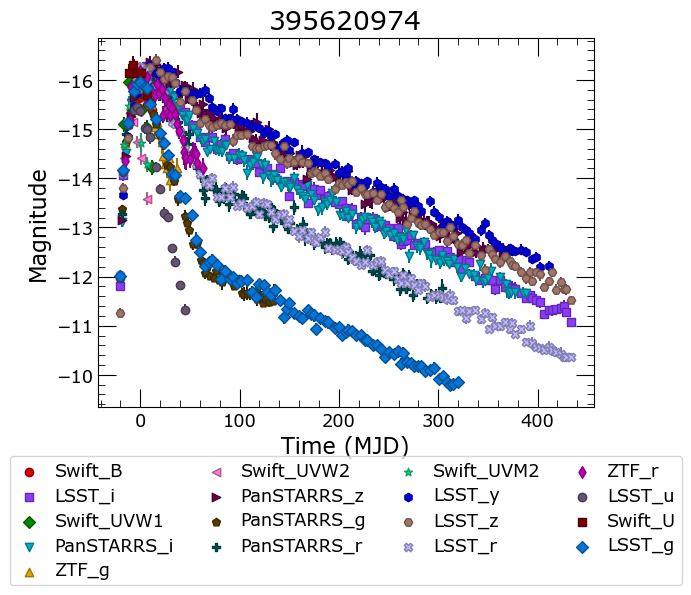

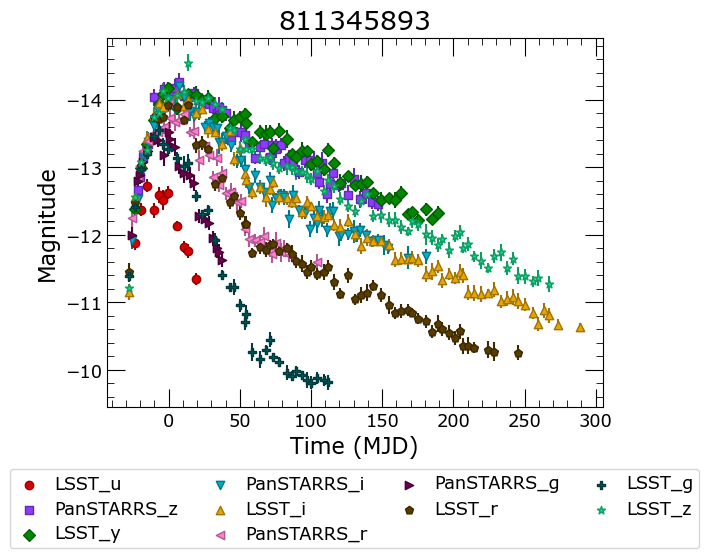

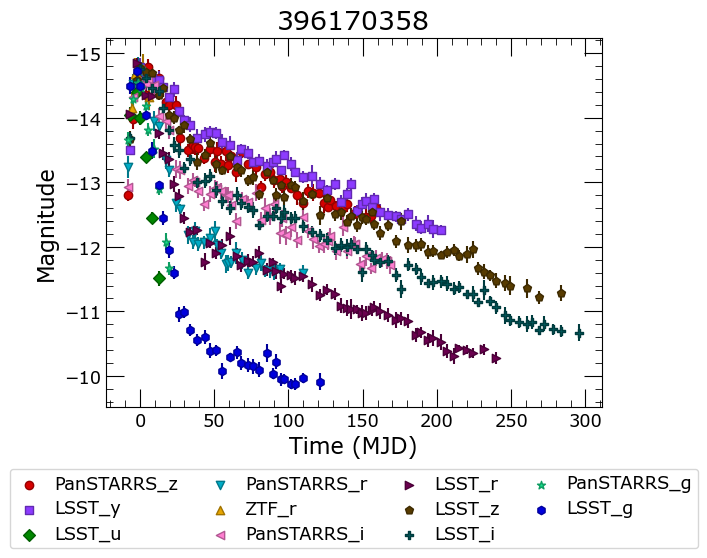

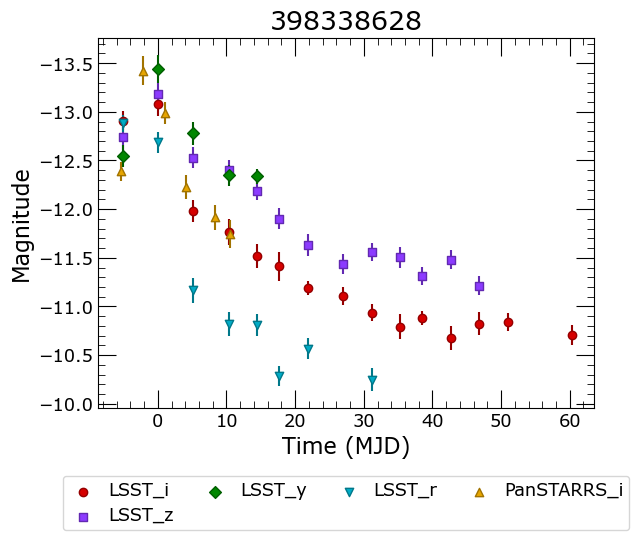

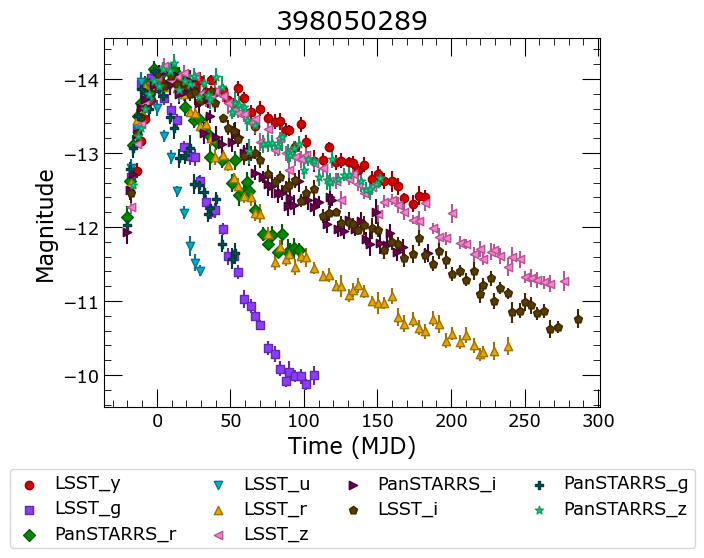

In [ ]:
# check LC quality
from snapi import Formatter, Transient
import glob
import matplotlib.pyplot as plt

formatter = Formatter()
for fn in glob.glob("snapi_transients_simulated/*.hdf5")[:5]:
    fig, ax = plt.subplots()
    transient = Transient.load(fn)
    transient.photometry.plot(ax, formatter=formatter)
    plt.title(transient.id)
    formatter.make_plot_pretty(ax)
    formatter.add_legend(ax)
    plt.show()
    formatter.reset_colors()
    formatter.reset_markers()

## Data Augmentation
Here we randomly augment the LCs via sub-sampling and only including certain regions.

In [ ]:
import glob
import os
import numpy as np
from snapi import Transient, Photometry
rng = np.random.default_rng()

save_dir = "snapi_transients_augmented"
os.makedirs(save_dir, exist_ok=True)
all_fns = glob.glob("snapi_transients_simulated/*.hdf5")

for i, fn in enumerate(all_fns):
    if i % 100 == 0:
        print(f"Augmented {i} out of {len(all_fns)} transients...")
    transient = Transient.load(fn)
    
    aug_set1 = set()
    aug_set2 = set()
    aug_set3 = set()

    rand_mint = rng.uniform(low=np.min(transient.photometry.times), high=np.max(transient.photometry.times))
    rand_maxt = rng.uniform(low=rand_mint, high=np.max(transient.photometry.times))

    # add phase wiggles of sigma = 3 days (to account for cadence)
    phase_wiggles = rng.normal(loc=0., scale=3., size=3)

    for lc in transient.photometry.light_curves:
        # first, resample 3 times
        resampled_mags = lc.resample(mags=True, num=3)

        # augment 1: just resample at existing times
        aug = lc.copy()
        aug.mags = resampled_mags[0]
        aug_set1.add(aug)

        # augment 2: resample, then subsample LC
        aug1 = lc.copy()
        aug1.mags = resampled_mags[1]
        if len(aug1.times) > 5:
            subsample_num = rng.integers(low=5, high=min(len(aug1.times), 32))
            aug1.subsample(subsample_num)
        aug_set2.add(aug1)

        # augment 3: resample, truncate, then subsample
        aug2 = lc.copy()
        aug2.mags = resampled_mags[2]
        aug2.truncate(max_t=rand_maxt, min_t=rand_mint)
        if len(aug2.times) < 5:
            continue
        if len(aug2.times) > 5:
            subsample_num2 = rng.integers(low=5, high=min(len(aug2.times), 32))
            aug2.subsample(subsample_num2)
        aug_set3.add(aug2)


    for i, aug_lcs in enumerate([transient.photometry.light_curves, aug_set1, aug_set2, aug_set3]):
        if len(aug_lcs) < 2:
            continue
        augmented_photometry = Photometry(aug_lcs)
        augmented_photometry.phase() # re-phase
        if i > 0:
            augmented_photometry.phase(phase_wiggles[i-1]) # phase wiggle
        transient.photometry = augmented_photometry
        transient.save(
            os.path.join(save_dir, f"{transient.id}_{i}.hdf5")
        )


Augmented 0 out of 1217 transients...
Augmented 100 out of 1217 transients...
Augmented 200 out of 1217 transients...
Augmented 300 out of 1217 transients...
Augmented 400 out of 1217 transients...
Augmented 500 out of 1217 transients...
Augmented 600 out of 1217 transients...
Augmented 700 out of 1217 transients...
Augmented 800 out of 1217 transients...
Augmented 900 out of 1217 transients...
Augmented 1000 out of 1217 transients...
Augmented 1100 out of 1217 transients...
Augmented 1200 out of 1217 transients...


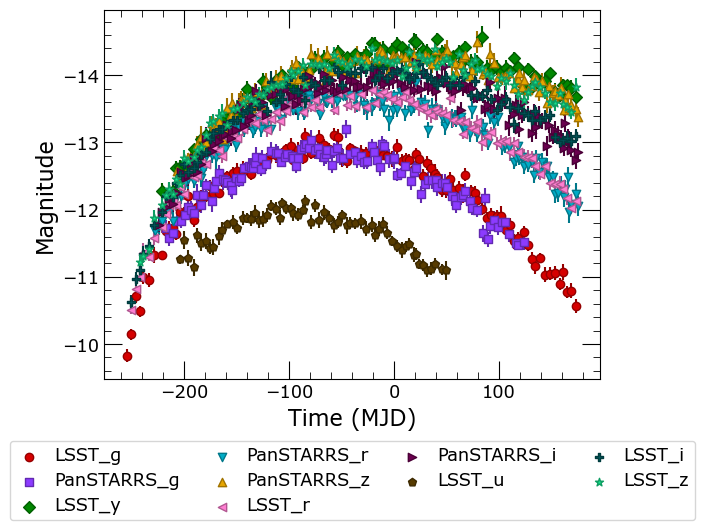

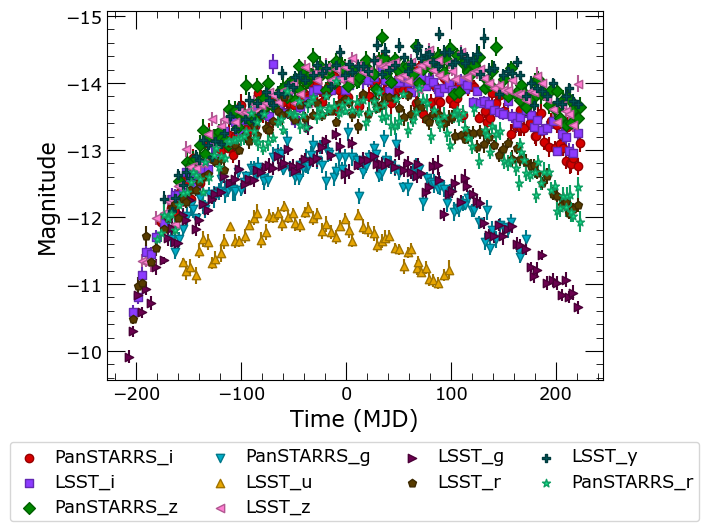

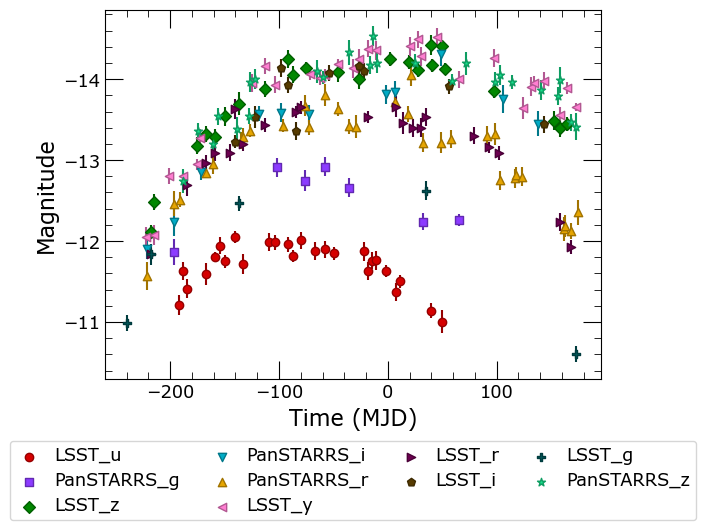

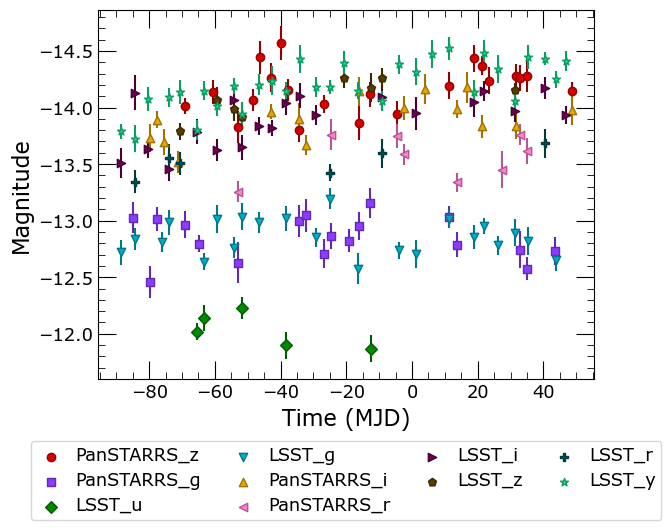

In [ ]:
# check augmentations for a LC
# check LC quality
from snapi import Formatter, Transient
import matplotlib.pyplot as plt

formatter = Formatter()
for i in range(4):
    fn = f"snapi_transients_augmented/811344797_{i}.hdf5"
    fig, ax = plt.subplots()
    transient = Transient.load(fn)
    transient.photometry.plot(ax, formatter=formatter)
    formatter.make_plot_pretty(ax)
    formatter.add_legend(ax)
    plt.show()
    formatter.reset_colors()
    formatter.reset_markers()

## Sanity check Pre-processing
During pre-processing, we create a 3d array containing the dense arrays of each light curve. We ensure that each light curve is tiled to 6 bands (where we repeat when necessary) to have uniformly-sized arrays.

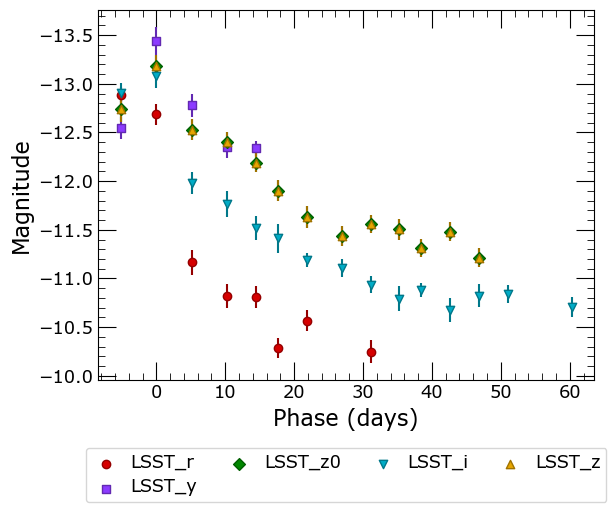

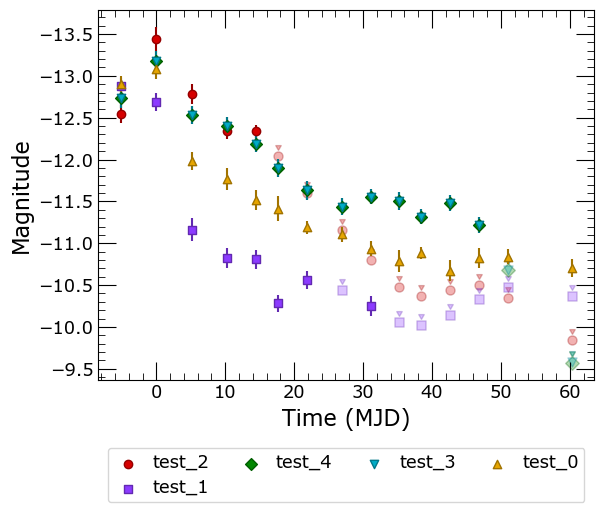

In [ ]:
import os
import shutil
from survey_agnostic_sn_vae.preprocessing import prep_input
from snapi import Photometry, LightCurve, Filter, Transient, Formatter
import astropy.units as u
from astropy.time import Time
import numpy as np
import matplotlib.pyplot as plt

formatter = Formatter()

orig_transient = Transient.load("test_data/398338628_0.hdf5")
orig_photometry = orig_transient.photometry
orig_photometry.tile(6)
orig_photometry.phase()
for lc in orig_photometry.light_curves:
    if str(lc.filter)[-1] == '0':
        repeat_instrument = lc.filter.instrument
        break
photometry = orig_photometry.filter_by_instrument(repeat_instrument)
dense_arr = photometry.dense_array()

#original
fig, ax = plt.subplots()
photometry.plot(ax=ax, formatter=formatter)
formatter.make_plot_pretty(ax)
formatter.add_legend(ax)
plt.show()

# recreated
nfilts = len(photometry)
times = dense_arr[:,0]
dense_mags = dense_arr[:,1:1+nfilts]
dense_mag_errs = dense_arr[:,1+nfilts:1+2*nfilts]
interpolated_mask = dense_arr[:,1+2*nfilts:1+3*nfilts]

rec_lcs = set()
for i in range(len(photometry)):
    recreation = LightCurve(
        times=Time(times, format='mjd'),
        mags=dense_mags[:,i],
        mag_errs=dense_mag_errs[:,i],
        upper_limits=interpolated_mask[:,i].astype(bool),
        filt = Filter(
            instrument="test",
            band=str(i),
            center=np.nan * u.AA
        )
    )
    rec_lcs.add(recreation)

formatter.reset_colors()
formatter.reset_markers()

fig, ax = plt.subplots()
photometry = Photometry(rec_lcs)
photometry.plot(ax=ax, formatter=formatter)
formatter.make_plot_pretty(ax)
formatter.add_legend(ax)
plt.show()


Pre-processed 0 out of 3 transients...
0.009408946476548326 3.263858342691151
{'ids': array(['398338628', '811344797', '811495301'], dtype='<U9'), 'classes': array([None, None, None], dtype=object)}


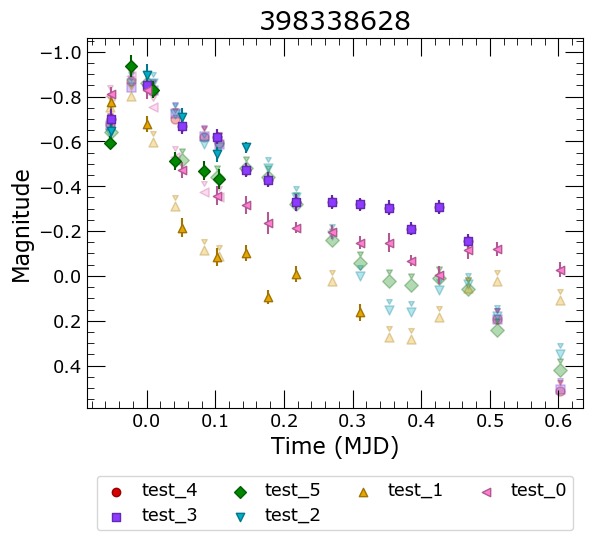

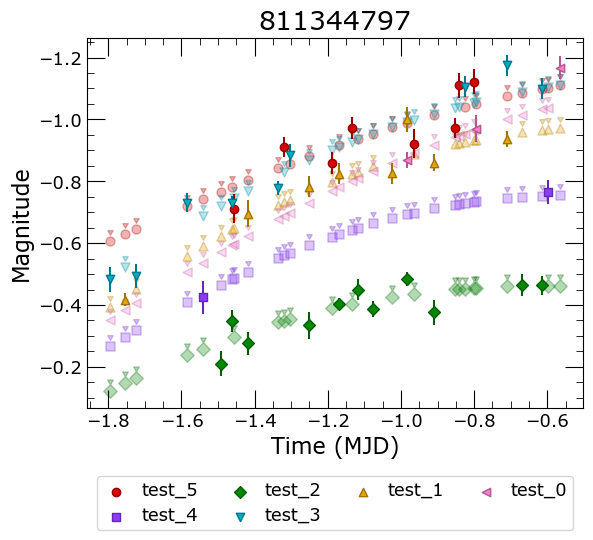

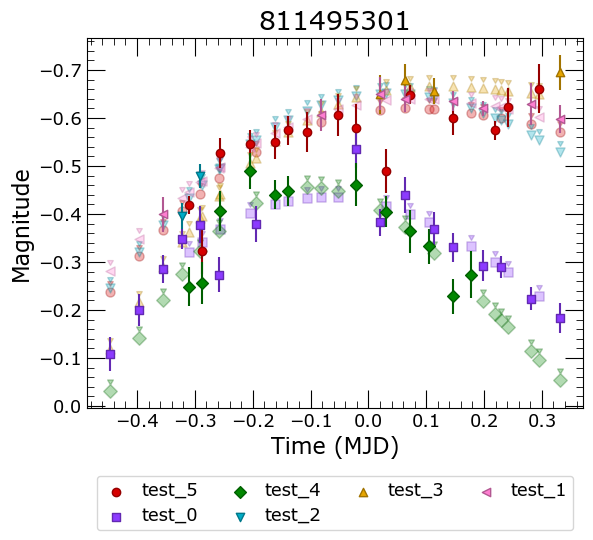

In [ ]:
# now check prep_input function
import os
import shutil
from snapi import Formatter, LightCurve, Photometry, Filter
import numpy as np
import matplotlib.pyplot as plt
from astropy.time import Time
import astropy.units as u
from survey_agnostic_sn_vae.preprocessing import prep_input

test_dir = "test_data"
shutil.rmtree(test_dir)
os.makedirs(test_dir, exist_ok=True)
shutil.copyfile("snapi_transients_augmented/398338628_1.hdf5", "test_data/398338628_1.hdf5")
shutil.copyfile("snapi_transients_augmented/811495301_2.hdf5", "test_data/811495301_2.hdf5")
shutil.copyfile("snapi_transients_augmented/811344797_2.hdf5", "test_data/811344797_2.hdf5")
dense_arr, meta_dict = prep_input(test_dir, save=True, outdir='.')
print(meta_dict)

for j in range(3):
    nfilts = 6
    times = dense_arr[j,:,0]
    dense_mags = dense_arr[j,:,1:1+nfilts]
    dense_mag_errs = dense_arr[j,:,1+nfilts:1+2*nfilts]
    interpolated_mask = dense_arr[j,:,1+2*nfilts:1+3*nfilts]

    rec_lcs = set()
    for i in range(nfilts):
        recreation = LightCurve(
            times=Time(times[times < 10.], format='mjd'),
            mags=-1*dense_mags[times < 10.,i],
            mag_errs=dense_mag_errs[times < 10.,i],
            upper_limits=interpolated_mask[times < 10.,i].astype(bool),
            filt = Filter(
                instrument="test",
                band=str(i),
                center=np.nan * u.AA
            )
        )
        rec_lcs.add(recreation)

    formatter = Formatter()

    fig, ax = plt.subplots()
    photometry = Photometry(rec_lcs)
    photometry.plot(ax=ax, formatter=formatter)
    ax.set_title(meta_dict['ids'][j])
    formatter.make_plot_pretty(ax)
    formatter.add_legend(ax)
plt.show()




In [ ]:
# now create full preprocessed file - save to HDF5
import warnings

warnings.filterwarnings("ignore")

from survey_agnostic_sn_vae.preprocessing import prep_input

dense_arr, meta_dict = prep_input(
    "snapi_transients_augmented",
    save=True,
    save_fn='preprocessed_augmented.h5'
)

Pre-processed 0 out of 4622 transients...
Pre-processed 50 out of 4622 transients...
Pre-processed 100 out of 4622 transients...
Pre-processed 150 out of 4622 transients...
Pre-processed 200 out of 4622 transients...
Pre-processed 250 out of 4622 transients...
Pre-processed 300 out of 4622 transients...
Pre-processed 350 out of 4622 transients...
Pre-processed 400 out of 4622 transients...
Pre-processed 450 out of 4622 transients...
Pre-processed 500 out of 4622 transients...
Pre-processed 550 out of 4622 transients...
Pre-processed 600 out of 4622 transients...
Pre-processed 650 out of 4622 transients...
Pre-processed 700 out of 4622 transients...
Pre-processed 750 out of 4622 transients...
Pre-processed 800 out of 4622 transients...
Pre-processed 850 out of 4622 transients...
Pre-processed 900 out of 4622 transients...
Pre-processed 950 out of 4622 transients...
Pre-processed 1000 out of 4622 transients...
Pre-processed 1050 out of 4622 transients...
Pre-processed 1100 out of 4622 tr

## Train RAENN

Here, we use the Equinox package, which is a neural network library built on JAX.

 (1) First try just VAE encodings without similarity loss

In [1]:
%env ENABLE_PJRT_COMPATIBILITY=1
from survey_agnostic_sn_vae.autoencoder.raenn_equinox import VAE, fit_model
import h5py
import time
import equinox as eqx

import jax

device = 'cpu'
jax.config.update('jax_platform_name', device)

# load data
with h5py.File('preprocessed_augmented.h5', 'r') as file:
    encoder_inputs = file['encoder_input'][:]
    ids = file['ids'][:]
    num_samples = len(encoder_inputs)
    train_encoder_inputs = encoder_inputs[:num_samples // 10 * 9]
    val_encoder_inputs = encoder_inputs[num_samples // 10 * 9:]
    train_ids = ids[:num_samples // 10 * 9]
    val_ids = ids[:num_samples // 10 * 9]

config = {
    "hidden_dim": 16,
    "out_dim": 4
}
# new model
#model = VAE(**config)
model_fn = "test_model_kl.eqx"

# load model
model = eqx.filter_eval_shape(VAE, **config)
model = eqx.tree_deserialise_leaves(model_fn, model)

start_time = time.time()
trained_model, loss, val_loss = fit_model(
    model=model,
    encoder_inputs=train_encoder_inputs,
    ids=train_ids,
    val_encoder_inputs=val_encoder_inputs,
    val_ids=val_ids,
    num_epochs=250,
    batch_size=128,
    learning_rate=1e-4,
    include_kl=True
)

print("LOSSES", loss)
print("ELAPSED TIME", time.time() - start_time)
eqx.tree_serialise_leaves("test_model_kl.eqx", trained_model)

env: ENABLE_PJRT_COMPATIBILITY=1


Platform 'METAL' is experimental and not all JAX functionality may be correctly supported!
W0000 00:00:1725380616.916130 6077089 mps_client.cc:510] WARNING: JAX Apple GPU support is experimental and not all JAX functionality is correctly supported!
I0000 00:00:1725380616.930546 6077089 service.cc:145] XLA service 0x166955f80 initialized for platform METAL (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1725380616.930559 6077089 service.cc:153]   StreamExecutor device (0): Metal, <undefined>
I0000 00:00:1725380616.932241 6077089 mps_client.cc:406] Using Simple allocator.
I0000 00:00:1725380616.932256 6077089 mps_client.cc:384] XLA backend will use up to 11452858368 bytes on device 0 for SimpleAllocator.


Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB

(926, 32, 31)
(8316, 32, 31)
Epoch 0: Training Log Loss=0.979, Validation Log Loss=1.212
Epoch 1: Training Log Loss=1.078, Validation Log Loss=1.288
Epoch 2: Training Log Loss=0.967, Validation Log Loss=1.193
Epoch 3: Training Log Loss=0.996, Validation Log Loss=1.229
Epoch 4: Training Log Loss=0.923, Validation Log Loss=1.175
Epoch 5: Training Log Loss=1.148, Validation Log Loss=1.302
Epoch 6: Training Log Loss=1.117, Validation Log Loss=1.337
Epoch 7: Training Log Loss=1.109, Validation Log Loss=1.288
Epoch 8: Training Log Loss=0.913, Validation Log Loss=1.145
Epoch 9: Training Log Loss=1.088, Validation Log Loss=1.291
Epoch 10: Training Log Loss=0.924, Validation Log Loss=1.176
Epoch 11: Training Log Loss=1.295, Validation Log Loss=1.493
Epoch 12: Training Log Loss=0.959, Validation Log Loss=1.189
Epoch 13: Training Log Loss=0.916, Validation Log Loss=1.166
Epoch 14: Training Log Loss=1.259, Validation 

2024-09-03 12:36:15.429628: E external/xla/xla/service/slow_operation_alarm.cc:133] The operation took 4m22.988349s
Constant folding an instruction is taking > 1s:

  %multiply.2167 = f32[926,192,1]{2,1,0} multiply(f32[926,192,1]{2,1,0} %constant.1728, f32[926,192,1]{2,1,0} %constant.1729)

This isn't necessarily a bug; constant-folding is inherently a trade-off between compilation time and speed at runtime. XLA has some guards that attempt to keep constant folding from taking too long, but fundamentally you'll always be able to come up with an input program that takes a long time.

If you'd like to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.


Epoch 78: Training Log Loss=0.882, Validation Log Loss=1.136
Epoch 79: Training Log Loss=0.92, Validation Log Loss=1.163
Epoch 80: Training Log Loss=0.978, Validation Log Loss=1.206
Epoch 81: Training Log Loss=0.91, Validation Log Loss=1.15
Epoch 82: Training Log Loss=0.886, Validation Log Loss=1.144
Epoch 83: Training Log Loss=0.892, Validation Log Loss=1.149
Epoch 84: Training Log Loss=1.029, Validation Log Loss=1.25
Epoch 85: Training Log Loss=0.978, Validation Log Loss=1.205
Epoch 86: Training Log Loss=0.889, Validation Log Loss=1.14
Epoch 87: Training Log Loss=0.965, Validation Log Loss=1.182
Epoch 88: Training Log Loss=1.207, Validation Log Loss=1.388
Epoch 89: Training Log Loss=1.087, Validation Log Loss=1.301
Epoch 90: Training Log Loss=1.005, Validation Log Loss=1.216
Epoch 91: Training Log Loss=0.953, Validation Log Loss=1.163
Epoch 92: Training Log Loss=1.015, Validation Log Loss=1.224
Epoch 93: Training Log Loss=0.955, Validation Log Loss=1.183
Epoch 94: Training Log Loss=0

2024-09-03 12:48:41.622249: E external/xla/xla/service/slow_operation_alarm.cc:133] The operation took 4m30.630214s
Constant folding an instruction is taking > 1s:

  %reduce-window.41 = f32[29,1,1]{2,1,0} reduce-window(f32[926,32,6]{2,1,0} %constant.1069, f32[] %constant.607), window={size=32x32x6 stride=32x32x6 pad=1_1x0_0x0_0}, to_apply=%region_97.3275

This isn't necessarily a bug; constant-folding is inherently a trade-off between compilation time and speed at runtime. XLA has some guards that attempt to keep constant folding from taking too long, but fundamentally you'll always be able to come up with an input program that takes a long time.

If you'd like to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.


Epoch 153: Training Log Loss=0.962, Validation Log Loss=1.192
Epoch 154: Training Log Loss=0.929, Validation Log Loss=1.166
Epoch 155: Training Log Loss=1.084, Validation Log Loss=1.292
Epoch 156: Training Log Loss=1.0, Validation Log Loss=1.212
Epoch 157: Training Log Loss=0.904, Validation Log Loss=1.15
Epoch 158: Training Log Loss=0.929, Validation Log Loss=1.157
Epoch 159: Training Log Loss=1.004, Validation Log Loss=1.2
Epoch 160: Training Log Loss=0.959, Validation Log Loss=1.181
Epoch 161: Training Log Loss=0.918, Validation Log Loss=1.156
Epoch 162: Training Log Loss=0.885, Validation Log Loss=1.134
Epoch 163: Training Log Loss=0.892, Validation Log Loss=1.131
Epoch 164: Training Log Loss=0.901, Validation Log Loss=1.14
Epoch 165: Training Log Loss=0.906, Validation Log Loss=1.145
Epoch 166: Training Log Loss=0.899, Validation Log Loss=1.137
Epoch 167: Training Log Loss=0.887, Validation Log Loss=1.133
Epoch 168: Training Log Loss=0.912, Validation Log Loss=1.148
Epoch 169: Tra

Platform 'METAL' is experimental and not all JAX functionality may be correctly supported!
W0000 00:00:1725383734.609115 6129447 mps_client.cc:510] WARNING: JAX Apple GPU support is experimental and not all JAX functionality is correctly supported!
I0000 00:00:1725383734.632171 6129447 service.cc:145] XLA service 0x309506310 initialized for platform METAL (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1725383734.632196 6129447 service.cc:153]   StreamExecutor device (0): Metal, <undefined>
I0000 00:00:1725383734.635638 6129447 mps_client.cc:406] Using Simple allocator.
I0000 00:00:1725383734.635666 6129447 mps_client.cc:384] XLA backend will use up to 11452858368 bytes on device 0 for SimpleAllocator.


Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



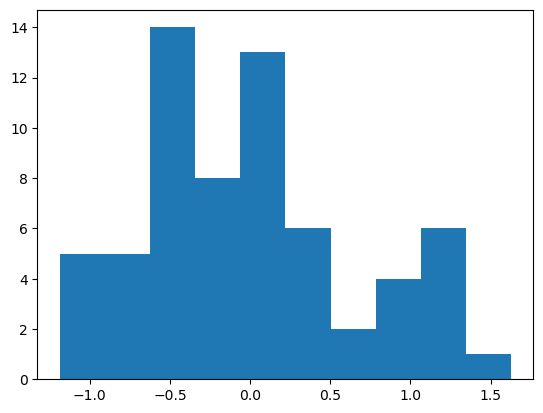

(5, 1600, 31)
(5, 32, 31)
(100, 32, 31)


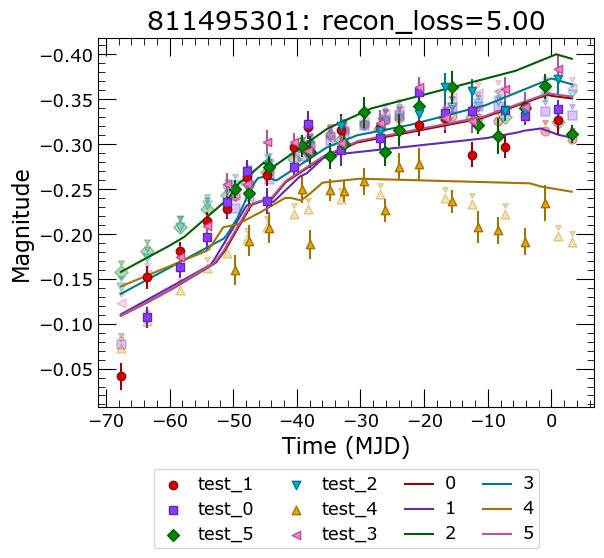

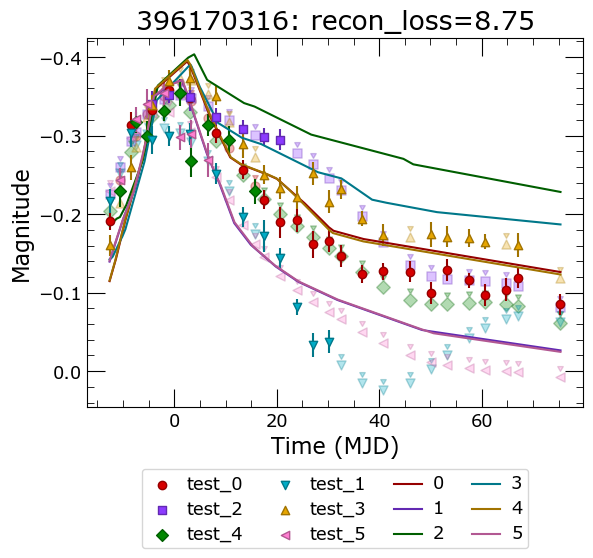

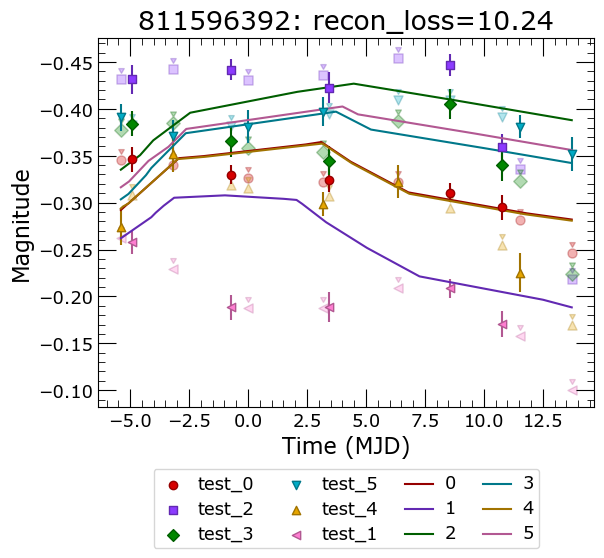

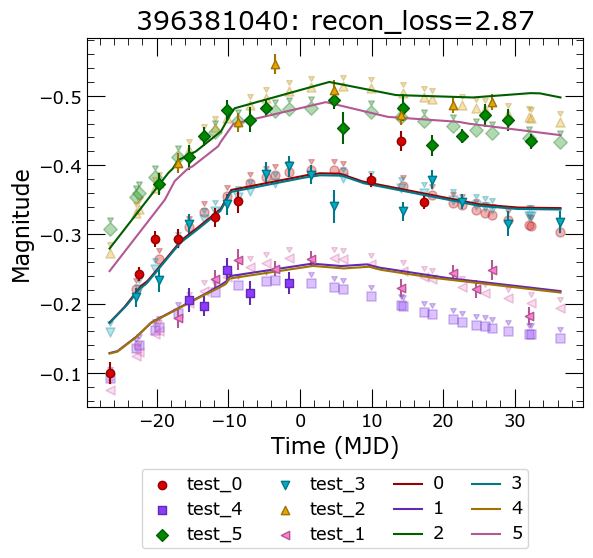

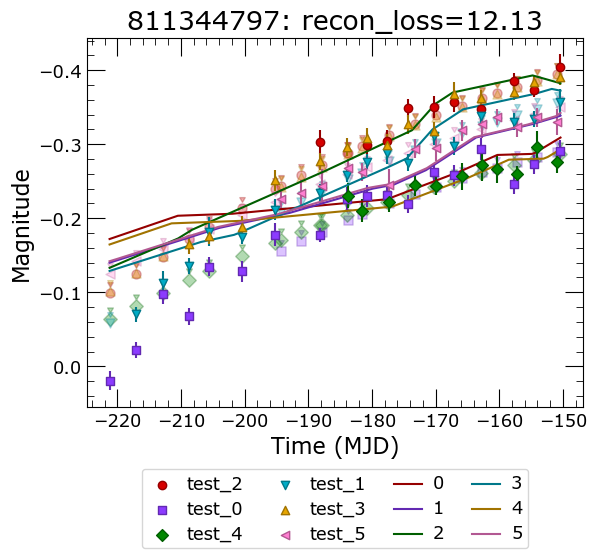

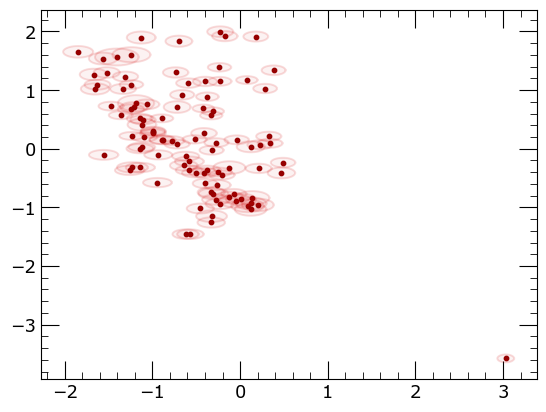

In [1]:
# now plot decodings
from survey_agnostic_sn_vae.autoencoder.vae_plotting import plot_decodings, plot_latent_space
from survey_agnostic_sn_vae.autoencoder.raenn_equinox import VAE
import h5py
import equinox as eqx
import matplotlib.pyplot as plt

preprocessed_fn = 'preprocessed_augmented.h5'
model_fn = 'test_model_kl.eqx'

config = {
    "hidden_dim": 16,
    "out_dim": 4
}

with h5py.File(preprocessed_fn, "r") as f:
    ids = f['ids'][:]
    encoder_inputs = f['encoder_input'][:]
    
# load model
model = eqx.filter_eval_shape(VAE, **config)
model = eqx.tree_deserialise_leaves(model_fn, model)

weights = model.latent_logvar.weight
plt.hist(weights.ravel())
plt.show()

for (fig, ax) in plot_decodings(
        encoder_inputs, ids,
        model,
        count=5
    ):
    fig.show()


# plot latent space
fig, ax = plot_latent_space(encoder_inputs, model)
fig.show()


In [ ]:
# run W&B sweep
import os
from survey_agnostic_sn_vae.autoencoder.wandb_sweeps import wandb_sweep

save_dir = 'sweep_data'
data_fn = 'preprocessed_augmented.h5'
os.makedirs(save_dir, exist_ok=True)

wandb_sweep(
    sweep_config_dir,
    data_fn,
    save_dir,
    num_runs=10,
)



# ARCHIVED OR INCOMPLETE

In [ ]:
from survey_agnostic_sn_vae.preprocessing import prep_input
from survey_agnostic_sn_vae.archival.raenn import *
import pretty_errors

OUTDIR = 'superraenn'
LCFILE = 'superraenn/lcs.npz'

device = 'cpu'
batch_size=128

sequence, outseq, loss_mask, meta_dict = prep_input(LCFILE, save=True, outdir=OUTDIR)
sequence_copy = np.copy(sequence)
outseq_copy = np.copy(outseq)

"""
model = VAE(
    sequence[:,:,:-1].shape,
    hidden_dim=100,
    latent_dim=4,
    device=device
)

model_fn = os.path.join(OUTDIR, "models_contrastive/model_2024-05-13_2_100.pt")
model = torch.load(model_fn).to(device)
model.device = device
model.maxlen = 32

model = fit_model(
        model, sequence, outseq, loss_mask,
        n_epochs=1000, device=device,
        batch_size=batch_size, learning_rate=1e-3,
        add_contrastive=False,
        latent_space_plot_dir=None
)
model.save(
    outdir=OUTDIR,
)
dataset = SNDataset(sequence[:,:,:-1], outseq, sequence[:,0,-1], loss_mask, device=device)
model.save_outputs(
    dataset, ids=ids, outdir=OUTDIR
)
"""
for metric in [
    #"cosine_means",
    #'cosine', 'euclidean',
    #'euclidean_means',
    'mahalonobis',
    'wasserstein'
]:
    #model_fn = os.path.join(OUTDIR, "models/model_2024-05-17_2_100.pt")
    model_fn = os.path.join(OUTDIR, f"contrastive2_{metric}/model_2_100.pt")
    model = torch.load(model_fn).to(device)
    model.device = device
    model.maxlen = 32
    print(metric)
    model = fit_model(
        model, sequence, outseq, loss_mask,
        n_epochs=500, device=device,
        batch_size=batch_size, learning_rate=1e-4,
        add_contrastive=True, metric=metric, temp=1.0,
        latent_space_plot_dir='figs/latent_space'
    )
    os.makedirs(f'superraenn/contrastive2_{metric}', exist_ok=True)
    model.save(
        outdir=OUTDIR,
        model_dir=f'contrastive2_{metric}',
    )
    dataset = SNDataset(sequence[:,:,:-1], outseq, sequence[:,0,-1], loss_mask, device=device)
    model.save_outputs(
        dataset, meta=meta_dict, outdir=OUTDIR, model_dir=f'contrastive2_{metric}'
    )


ModuleNotFoundError: No module named 'torch'

In [ ]:
from sklearn.model_selection import train_test_split
# compare inter-modal and cross-modal reconstructions for each metric
import torch
import os
from survey_agnostic_sn_vae.preprocessing import prep_input
from survey_agnostic_sn_vae.archival.raenn import SNDataset
from survey_agnostic_sn_vae.metrics import *
LCFILE = 'superraenn/lcs.npz'
OUTDIR = 'superraenn'
PREPFILE = 'superraenn/prep.npz'

sequence, outseq, loss_mask, meta_dict = prep_input(
    LCFILE, load=True, outdir=OUTDIR, prep_file=PREPFILE
)
device = 'cpu'
seq_ids = sequence[:,0,-1]
sequence = sequence[:,:,:-1]

(
    train_seq, test_seq,
    train_out, test_out,
    train_id, test_id,
    train_mask, test_mask
) = train_test_split(
    sequence, outseq,
    seq_ids, loss_mask,
    shuffle=False,
    test_size=0.2
)

dataset = SNDataset(test_seq, test_out, test_id, test_mask, device=device)
train_dataset = SNDataset(train_seq, train_out, train_id, train_mask, device=device)

device='cpu'
for metric in [
    'cosine_means', 'cosine', 'euclidean', 'euclidean_means',
    'mahalonobis', 'wasserstein'
]:
    model_fn = os.path.join(OUTDIR, f"contrastive_{metric}/model_2024-05-29_2_100.pt")
    model = torch.load(model_fn).to(device)
    print(metric)
    print(calc_cross_modal_weighted_mse(model, dataset))
    print(calc_inter_modal_weighted_mse(model, dataset))
    print(calc_cross_modal_weighted_mse(model, train_dataset))
    print(calc_inter_modal_weighted_mse(model, train_dataset))

cosine_means
22.27439308166504
19.535646438598633
23.43224334716797
17.67462158203125
cosine
25.417800903320312
20.026538848876953
25.010828018188477
17.99529457092285
euclidean
20.7857723236084
20.65812110900879
18.952260971069336
17.858882904052734
euclidean_means
19.41083335876465
20.83446502685547
19.101354598999023
18.192901611328125
mahalonobis
20.164215087890625
17.738910675048828
17.4075984954834
16.672931671142578
wasserstein
20.497554779052734
19.242748260498047
19.344745635986328
16.892650604248047


32


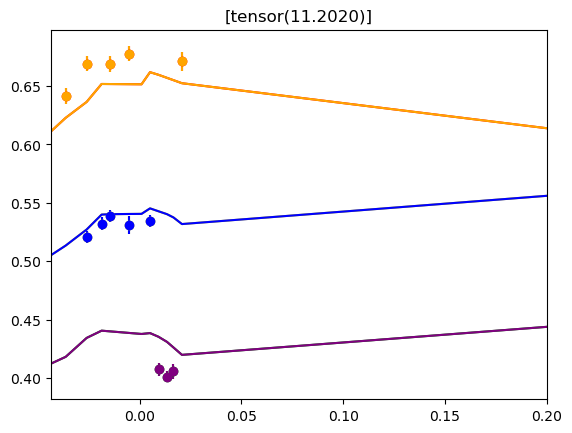

32


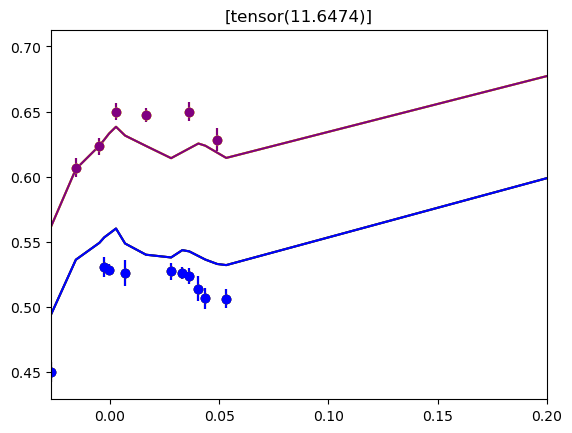

32


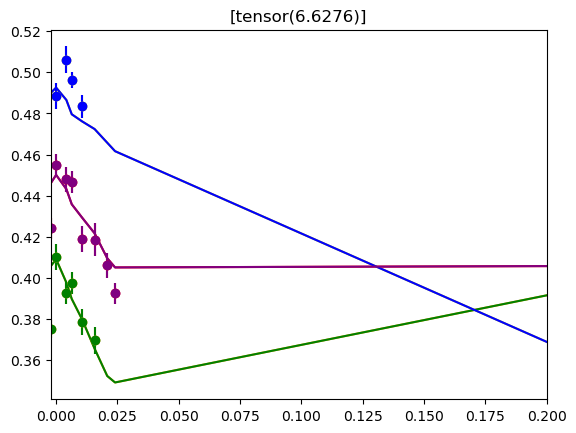

32


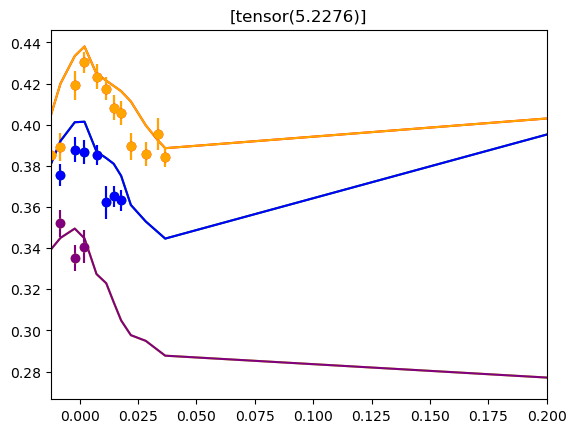

32


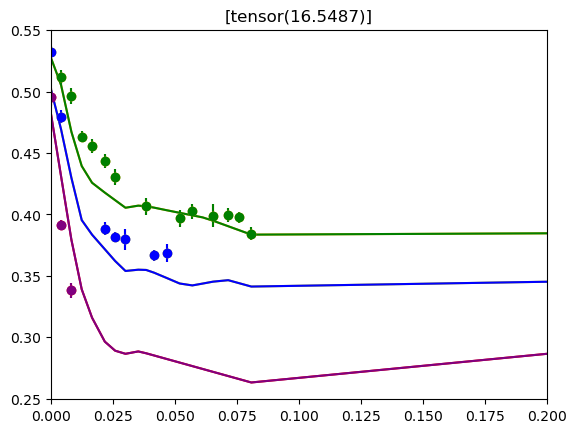

32


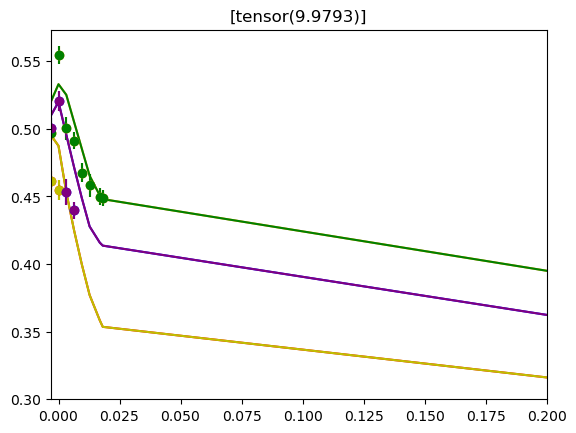

32


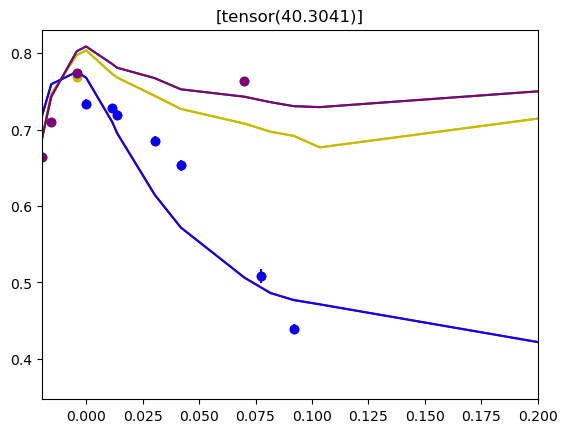

32


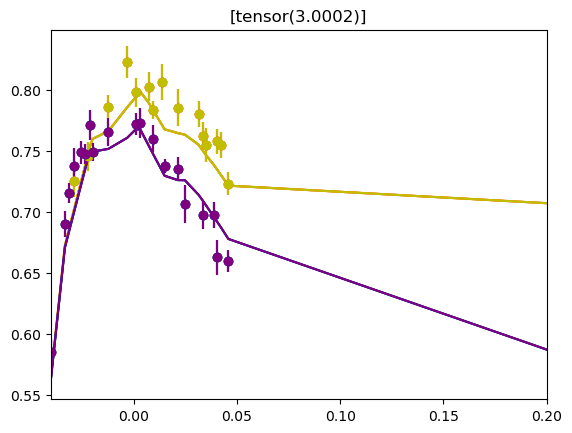

32


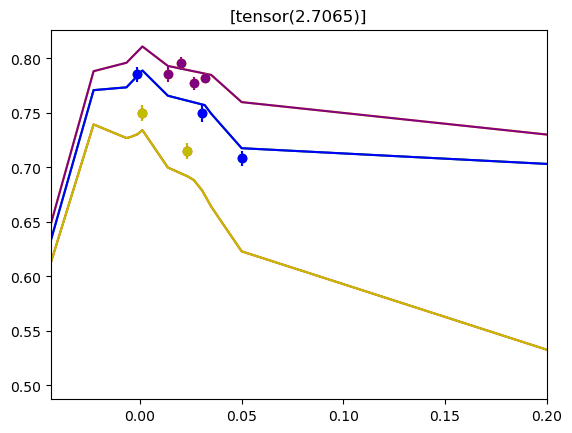

32


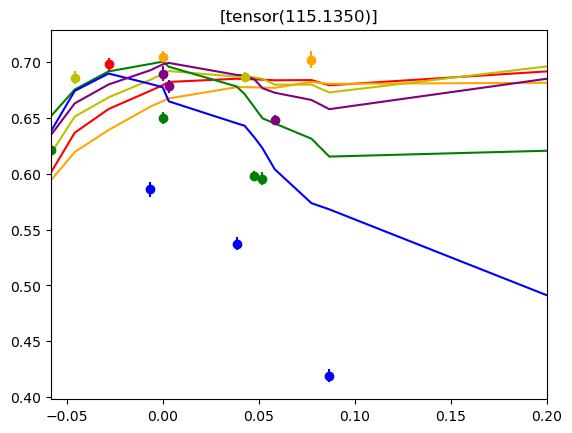

"\n# plot original LC to see where extra point at 0 comes from\nlcs = np.load(LCFILE, allow_pickle=True)['lcs']\nlc = lcs[0]\n\nfor b in range(6):\n    #plt.scatter(lc.times[lc.filters==b], -lc.abs_mags[lc.filters==b], c=colors[b])\n    plt.scatter(lc.dense_times, -lc.dense_lc[:,b,0], c=colors[b])\nplt.show()\n"

In [ ]:
# plot decodings
import os
from survey_agnostic_sn_vae.preprocessing import prep_input
import matplotlib.pyplot as plt
import numpy as np
import torch
from survey_agnostic_sn_vae.archival.raenn import *

LCFILE = 'superraenn/lcs.npz'
OUTFILE = 'superraenn/outputs/out.npz'
OUTDIR = 'superraenn'

sequence, outseq, loss_mask, meta_dict = prep_input(LCFILE, save=True, outdir=OUTDIR)
device = 'cpu'
model_fn = os.path.join(OUTDIR, "contrastive_mahalonobis/model_2024-05-29_3_100.pt")
model = torch.load(model_fn).to(device)
model.device = device

dataset = SNDataset(sequence[:,:,:-1], outseq, sequence[:,0,-1], loss_mask, device=device)
model.save_outputs(
    dataset, meta=meta_dict, outdir=OUTDIR
)

out = np.load(OUTFILE, allow_pickle=True)
decodings = out['decodings']
z_means = out['z_means']
z_logvars = out['z_logvars']

#assert(len(np.unique(ids)) == len(ids))
#assert(len(np.unique(ids2)) == len(ids2))
#assert np.all(ids == ids2)

for i in range(10):
    dec = decodings[i]
    seq = sequence[i]
    loss_mask_x = loss_mask[i]
    z_mean = z_means[i:i+1]
    z_logvar = z_logvars[i:i+1]
    
    t = seq[:,0]
    print(len(t))
    f = seq[:,1:7]
    ferr = seq[:,7:13]

    colors = ['r','orange','y','g','b','purple']
    for b in range(6):
        mask = loss_mask_x[:,b].astype(bool)
        plt.errorbar(t[~mask], f[:,b][~mask], yerr=ferr[:,b][~mask], fmt='o', c=colors[b])
        plt.plot(t, dec[:,b], c=colors[b])
        
    l = loss_function(
        torch.from_numpy(seq[np.newaxis,:,:]),
        torch.from_numpy(dec[np.newaxis,:,:]),
        torch.from_numpy(loss_mask_x[np.newaxis,:,:]).bool(), 6,
        z_mean, z_logvar, None, None,
    )
    plt.title(l)
    plt.xlim((np.min(t), 0.2))
    plt.show()

"""
# plot original LC to see where extra point at 0 comes from
lcs = np.load(LCFILE, allow_pickle=True)['lcs']
lc = lcs[0]

for b in range(6):
    #plt.scatter(lc.times[lc.filters==b], -lc.abs_mags[lc.filters==b], c=colors[b])
    plt.scatter(lc.dense_times, -lc.dense_lc[:,b,0], c=colors[b])
plt.show()
"""


## Apply model to YSE + ZTF light curves

In [ ]:
from dustmaps.sfd import SFDQuery
from astropy.coordinates import SkyCoord
import astropy.units as u
sfd = SFDQuery()
coord = SkyCoord(ra=240.6168588*u.deg, dec=12.5462438*u.deg)
sfd(coord)

0.036149777

In [ ]:
# Import data from both YSE and ZTF
# first do ZTF
import os
from survey_agnostic_sn_vae.data_imports.import_ztf import generate_ztf_transients

SAVE_DIR = 'snapi_transients'
os.makedirs(SAVE_DIR, exist_ok=True)
generate_ztf_transients(SAVE_DIR)

STARTS
Processed 0 of 16167 objects.
Processed 1000 of 16167 objects.
Processed 2000 of 16167 objects.
Processed 3000 of 16167 objects.
Processed 4000 of 16167 objects.
Processed 5000 of 16167 objects.
Processed 6000 of 16167 objects.
Processed 7000 of 16167 objects.
Processed 8000 of 16167 objects.
Processed 9000 of 16167 objects.
Processed 10000 of 16167 objects.
Processed 11000 of 16167 objects.
Processed 12000 of 16167 objects.
Processed 13000 of 16167 objects.
Processed 14000 of 16167 objects.
Processed 15000 of 16167 objects.
Processed 16000 of 16167 objects.


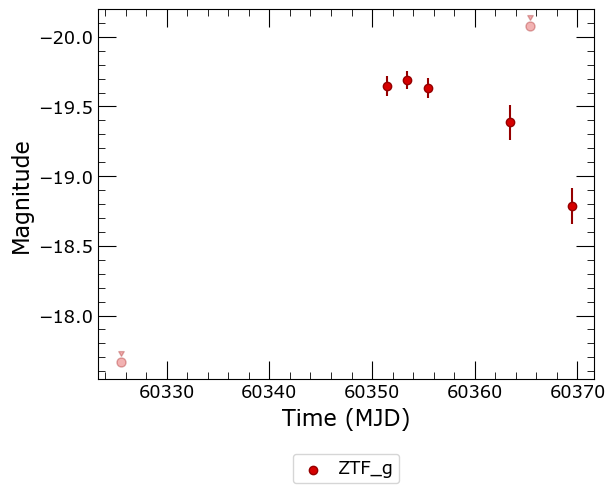

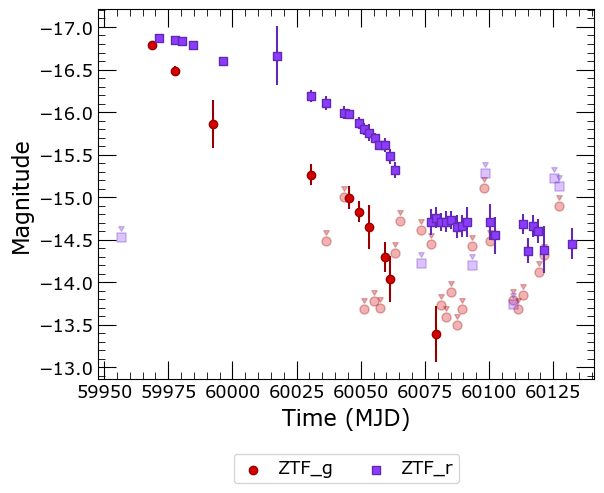

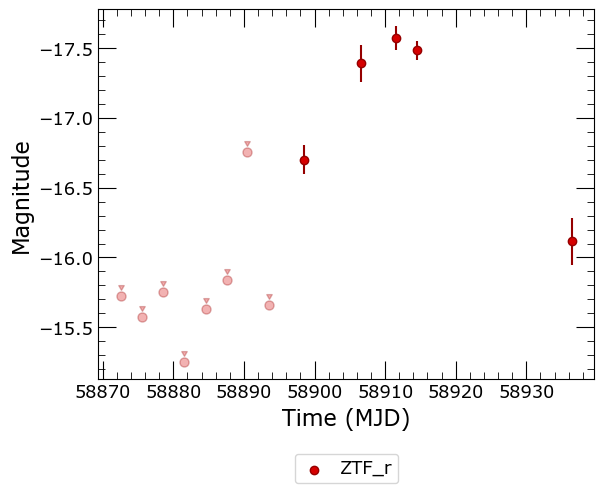

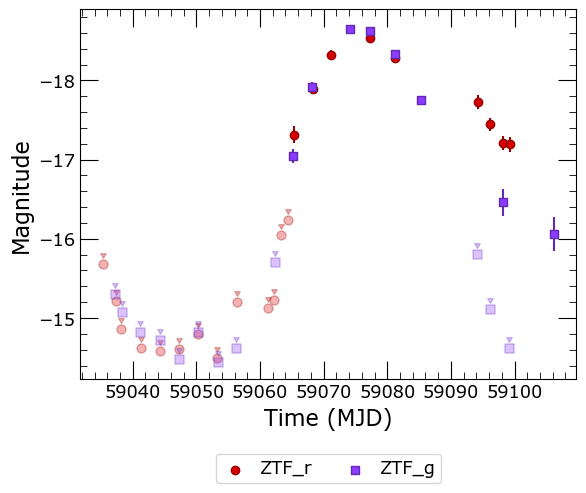

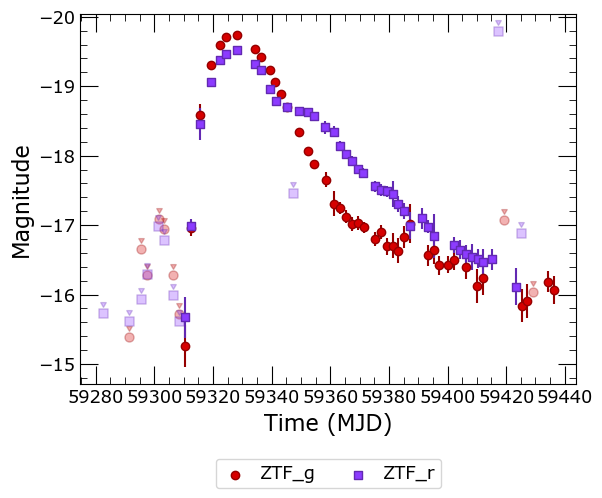

0


In [ ]:
# plot some ZTF LCs
from snapi import Formatter, Transient
import glob
import matplotlib.pyplot as plt

formatter = Formatter()
for fn in glob.glob("snapi_transients/*.hdf5")[:5]:
    fig, ax = plt.subplots()
    transient = Transient.load(fn)
    transient.photometry.plot(ax, formatter=formatter)
    formatter.make_plot_pretty(ax)
    formatter.add_legend(ax)
    plt.show()
    formatter.reset_colors()
    formatter.reset_markers()


In [ ]:
# copy folder to separate folder for modification
import shutil, os

if os.path.exists("snapi_transients_combined"):
    shutil.rmtree("snapi_transients_combined")
shutil.copytree("snapi_transients", "snapi_transients_combined", )

'snapi_transients_combined'

In [ ]:
# add YSE data
from survey_agnostic_sn_vae.data_imports.import_yse_dr1 import generate_yse_transients

generate_yse_transients(
    'yse_dr1_zenodo_snr_geq_4',
    'snapi_transients_combined'
)

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900


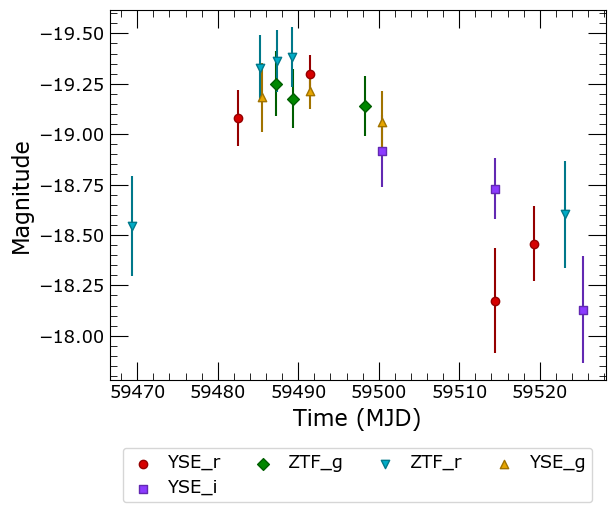

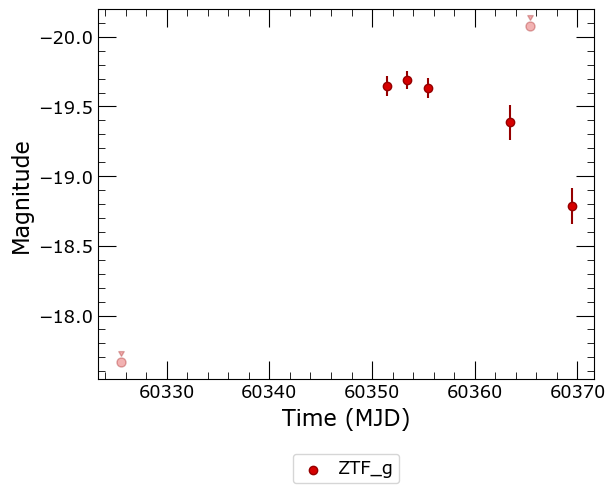

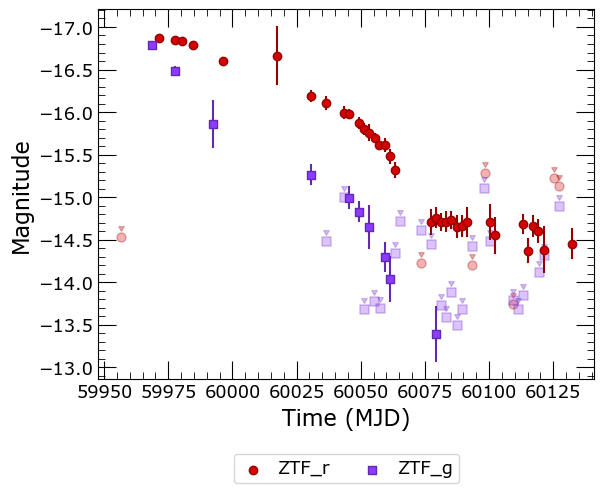

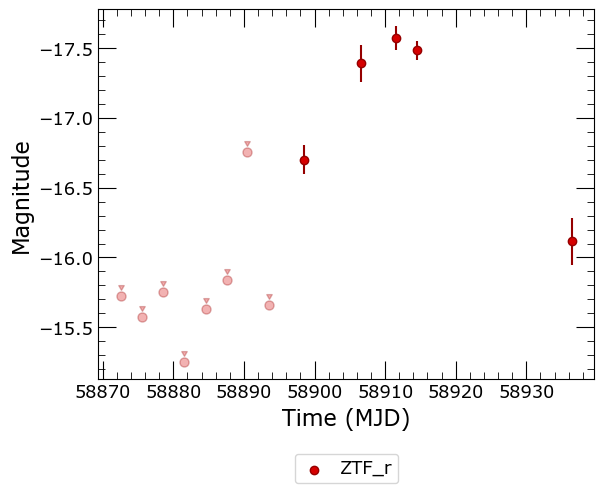

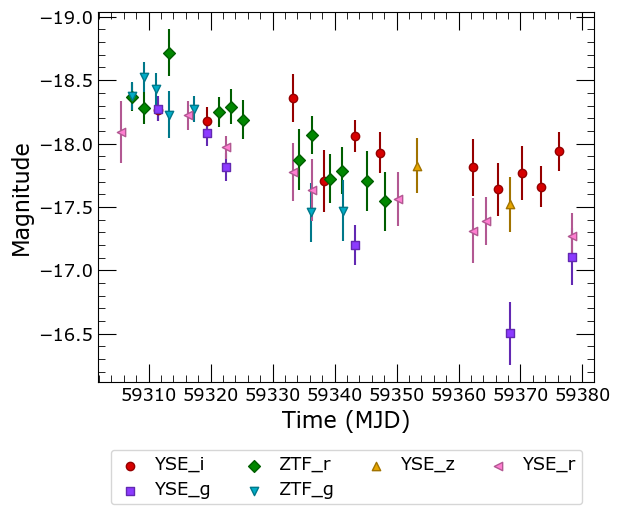

2


In [ ]:
# plot combined LC
from snapi import Formatter, Transient
import glob
import matplotlib.pyplot as plt

num_without_coords = 0
formatter = Formatter()
for fn in glob.glob("snapi_transients_combined/*.hdf5")[:5]:
    fig, ax = plt.subplots()
    transient = Transient.load(fn)
    if transient.coordinates is None:
        num_without_coords += 1
    transient.photometry.plot(ax, formatter=formatter)
    formatter.make_plot_pretty(ax)
    formatter.add_legend(ax)
    plt.show()
    formatter.reset_colors()
    formatter.reset_markers()

print(num_without_coords)



In [ ]:
from survey_agnostic_sn_vae.preprocessing import prep_input
from survey_agnostic_sn_vae.archival.raenn import *

# augment trained models with YSE data
OUTDIR = 'superraenn/yse'
LCFILE = 'superraenn/yse/lcs_merged.npz'
PREPFILE = 'superraenn/prep.npz'

device = 'cpu'
batch_size=128

sequence, outseq, loss_mask, meta_dict = prep_input(
    LCFILE, load=True, outdir=OUTDIR, prep_file=PREPFILE
)

model_fn = "superraenn/yse/models_contrastive/model.pt"
#model_fn = "superraenn/contrastive_mahalonobis/model_3_100.pt"
#model_fn = "superraenn/models/model_2024-05-16_3_100.pt"
model = torch.load(model_fn).to(device)
model.device = device
model.maxlen = sequence.shape[1]

os.makedirs('figs/yse_latent_space', exist_ok=True)

model = fit_model(
    model, sequence, outseq, loss_mask,
    n_epochs=500, device=device,
    batch_size=batch_size, learning_rate=1e-4,
    add_contrastive=True,
    metric='mahalonobis', temp=1.0,
    latent_space_plot_dir='figs/yse_latent_space'
)
os.makedirs('superraenn/yse/models_contrastive', exist_ok=True)
model.save(
    outdir=OUTDIR,
    model_dir='models_contrastive',
)

dataset = SNDataset(sequence[:,:,:-1], outseq, sequence[:,0,-1], loss_mask, device=device)
model.save_outputs(
    dataset, meta=meta_dict, outdir=OUTDIR
)


True
	Epoch 1 	Train Loss:  9.741148354714376 	Val Loss:  13.850984573364258
	Train [5.322737216949463, 2.9173519611358643, 1.4949586391448975] 	Test [11.690895080566406, 2.8141815662384033, 0.8875120878219604]
	Epoch 2 	Train Loss:  9.31048195822197 	Val Loss:  13.591435559590657
	Train [4.297049045562744, 2.7970340251922607, 3.3832693099975586] 	Test [11.920929908752441, 2.760077714920044, 0.4473090171813965]
	Epoch 3 	Train Loss:  9.027273855711284 	Val Loss:  13.232723871866861
	Train [5.653275489807129, 2.747062921524048, 1.40582275390625] 	Test [12.66504192352295, 2.736220121383667, 0.5664697885513306]
	Epoch 4 	Train Loss:  9.07848182477449 	Val Loss:  13.243605295817057
	Train [4.805119037628174, 2.776024580001831, 3.1327688694000244] 	Test [12.1615571975708, 2.745500087738037, 0.08831054717302322]
	Epoch 5 	Train Loss:  8.988065502099824 	Val Loss:  13.13760585784912
	Train [3.173121213912964, 2.725231647491455, 1.6466736793518066] 	Test [12.194830894470215, 2.740205764770508,

z_means
z_logvars
decodings
ids
surveys
classes
0.1698662 0.0036329713 0.0054382803
0.1698662 0.0051256544 0.006582417
0.1698662 0.0036329713 0.0054382803
0.1698662 0.0051256544 0.006582417
0.1698662 0.0022832365 0.0041320985
0.1698662 0.0022832365 0.0041320985


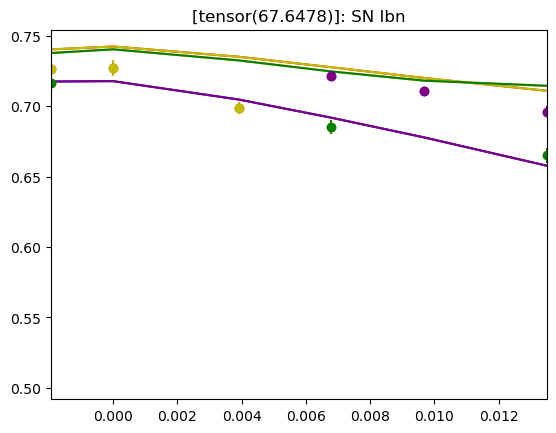

0.08894724 0.0071546547 0.014188617
0.08894724 0.009853542 0.014349618
0.08894724 0.009853542 0.014349618
0.08894724 0.009853542 0.014349618
0.08894724 0.0071546547 0.014188617
0.08894724 0.0071546547 0.014188617


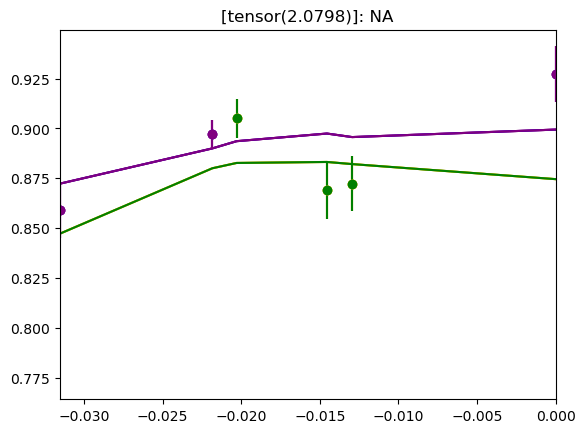

0.08275485 0.0073338826 0.013169325
0.08275485 0.008614208 0.015846578
0.08275485 0.008614208 0.015846578
0.08275485 0.008614208 0.015846578
0.08275485 0.0073338826 0.013169325
0.08275485 0.0073338826 0.013169325


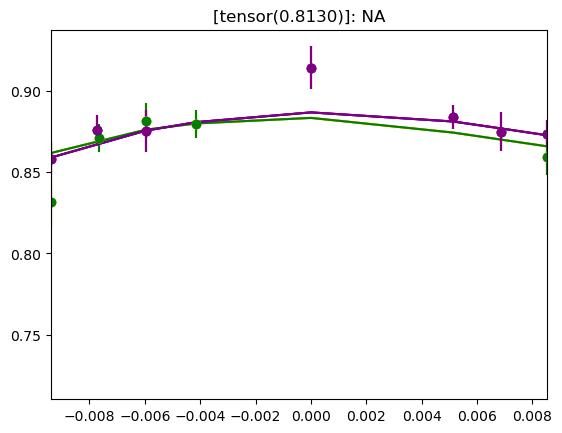

0.12846404 0.008255499 0.015307045
0.12846404 0.008974599 0.015451545
0.12846404 0.007878829 0.013405938
0.12846404 0.008255499 0.015307045
0.12846404 0.008974599 0.015451545
0.12846404 0.007878829 0.013405938


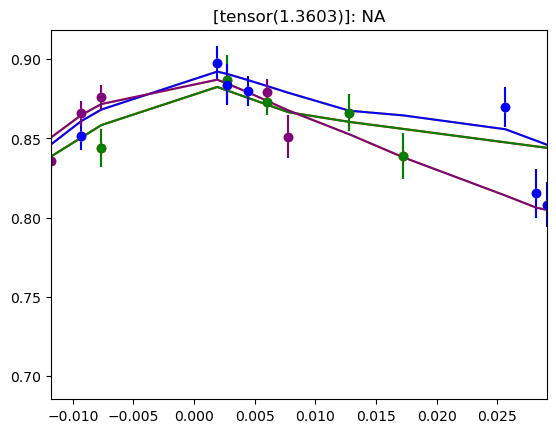

0.1363495 0.0073338826 0.013169325
0.1363495 0.008614208 0.015846578
0.1363495 0.008614208 0.015846578
0.1363495 0.0073338826 0.013169325
0.1363495 0.007878829 0.013405938
0.1363495 0.007878829 0.013405938


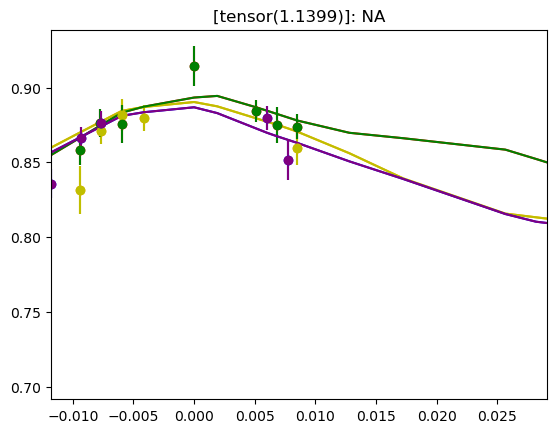

0.24341404 0.0024341403 0.013392602
0.24341404 0.0024341403 0.006542333
0.24341404 0.0024341403 0.006648126
0.24341404 0.0024341403 0.006542333
0.24341404 0.0024341403 0.006648126
0.24341404 0.0024341403 0.013392602


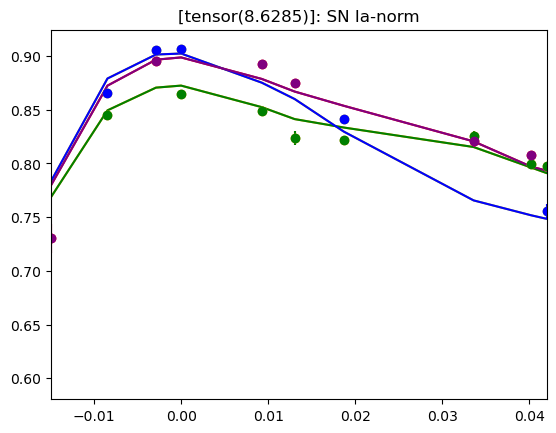

0.089087665 0.0059643826 0.0137051195
0.089087665 0.011737008 0.013448015
0.089087665 0.011737008 0.013448015
0.089087665 0.0059643826 0.0137051195
0.089087665 0.0059643826 0.0137051195
0.089087665 0.011737008 0.013448015


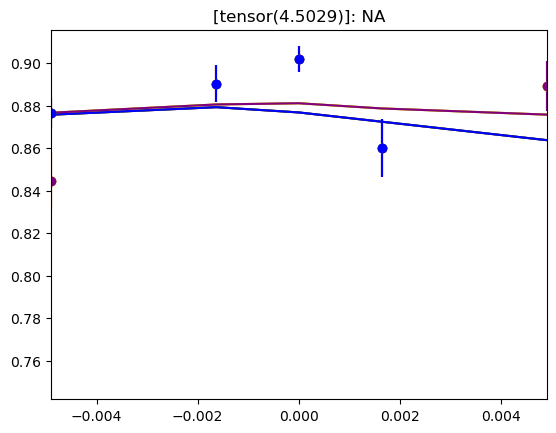

0.21551889 0.0030530675 0.0048855557
0.21551889 0.0024733313 0.003844398
0.21551889 0.0021551892 0.0043563778
0.21551889 0.0024733313 0.003844398
0.21551889 0.0021551892 0.0043563778
0.21551889 0.0030530675 0.0048855557


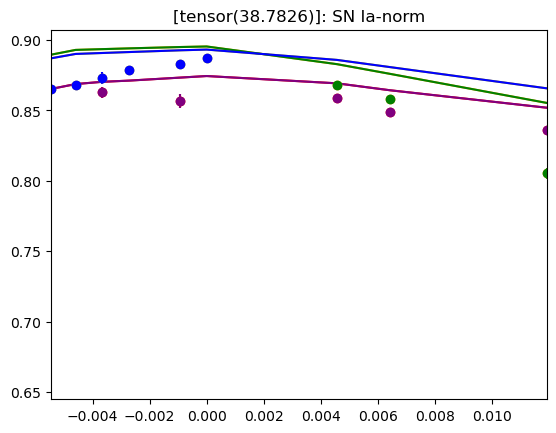

0.060380995 0.009343494 0.015305975
0.060380995 0.0073668114 0.014701984
0.060380995 0.0073668114 0.014701984
0.060380995 0.009343494 0.015305975
0.060380995 0.009343494 0.015305975
0.060380995 0.0073668114 0.014701984


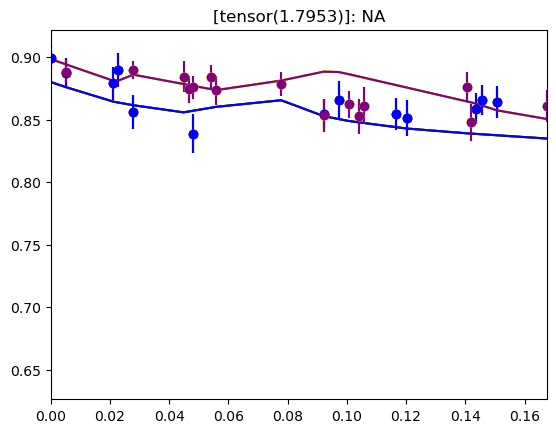

0.09897059 0.004899798 0.01564119
0.09897059 0.004899798 0.01564119
0.09897059 0.0051595448 0.013763206
0.09897059 0.0051595448 0.013763206
0.09897059 0.005913554 0.014603031
0.09897059 0.005913554 0.014603031


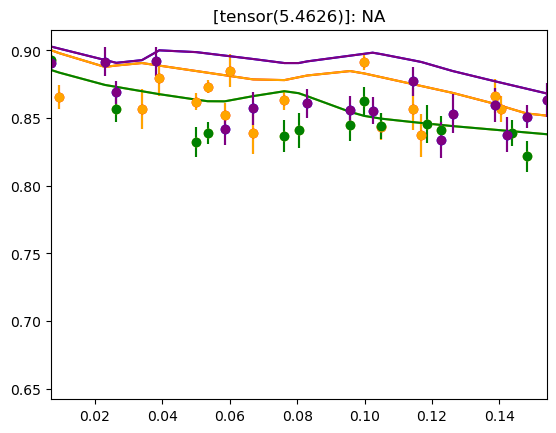

0.06719738 0.0073668114 0.012909971
0.06719738 0.0073668114 0.012909971
0.06719738 0.0051595448 0.013064689
0.06719738 0.009343494 0.015305975
0.06719738 0.009343494 0.015305975
0.06719738 0.0051595448 0.013064689


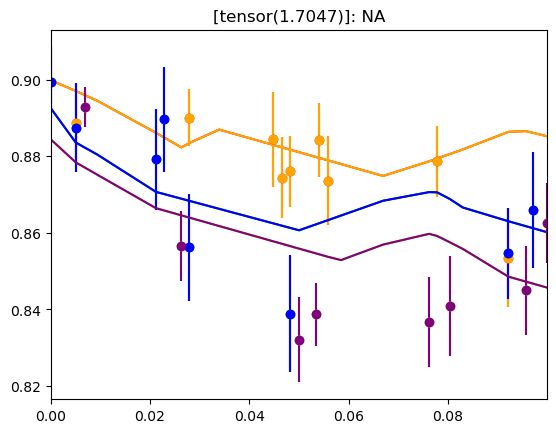

0.16989481 0.0016989487 0.0068936707
0.16989481 0.0017086653 0.01590803
0.16989481 0.0017086653 0.01590803
0.16989481 0.0017086653 0.01590803
0.16989481 0.0016989487 0.0068936707
0.16989481 0.0016989487 0.0068936707


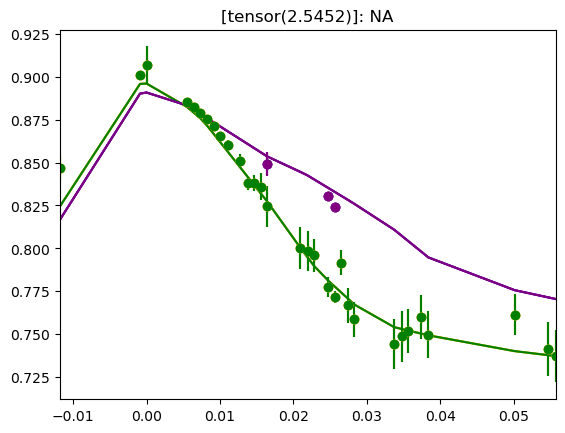

0.18818331 0.0018818327 0.015483866
0.18818331 0.002568833 0.012917042
0.18818331 0.002568833 0.012917042
0.18818331 0.0018818327 0.015483866
0.18818331 0.0018818327 0.015419773
0.18818331 0.0018818327 0.015419773


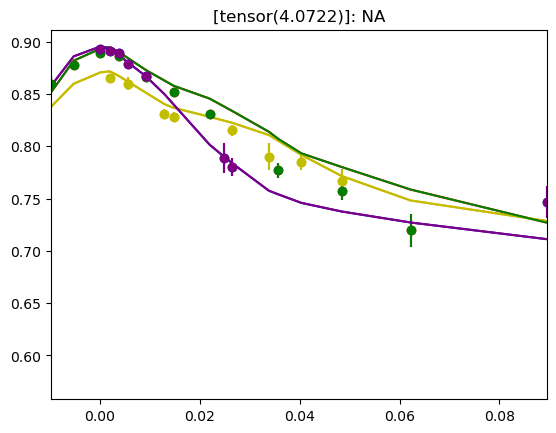

0.14035767 0.0017086653 0.012309739
0.14035767 0.0015439839 0.0068936707
0.14035767 0.0015439839 0.0068936707
0.14035767 0.0017086653 0.012309739
0.14035767 0.0016495663 0.013952163
0.14035767 0.0016495663 0.013952163


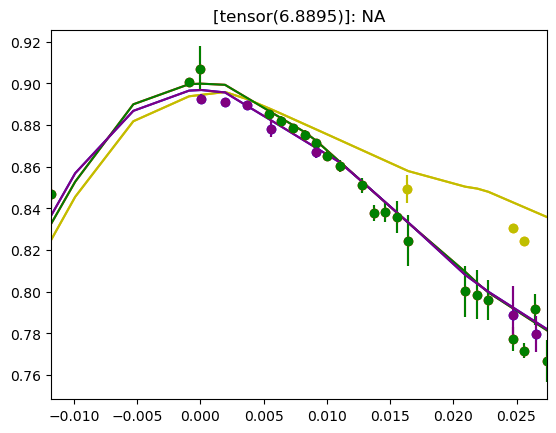

0.30176193 0.0030176193 0.0031441497
0.30176193 0.0030176193 0.005462568
0.30176193 0.0030176193 0.0031441497
0.30176193 0.0030176193 0.005462568
0.30176193 0.0030176193 0.0031441497
0.30176193 0.0030176193 0.005462568


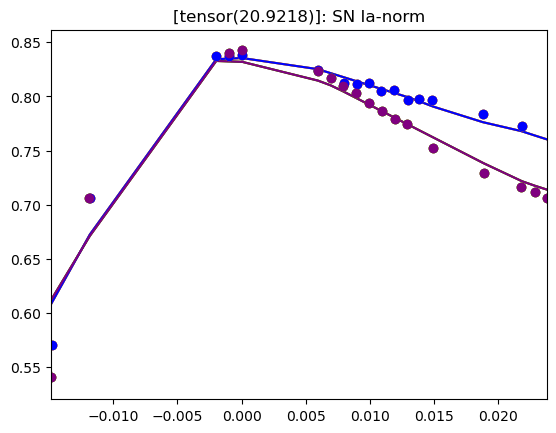

0.4544016 0.004544016 0.004544016
0.4544016 0.004544016 0.004544016
0.4544016 0.004544016 0.004544016
0.4544016 0.004544016 0.004544016
0.4544016 0.004544016 0.004544016
0.4544016 0.004544016 0.004544016


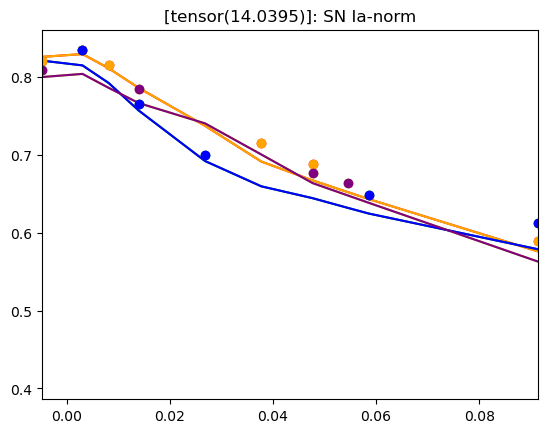

0.46290094 0.004629009 0.004629009
0.46290094 0.004629009 0.004629009


ValueError: zero-size array to reduction operation minimum which has no identity

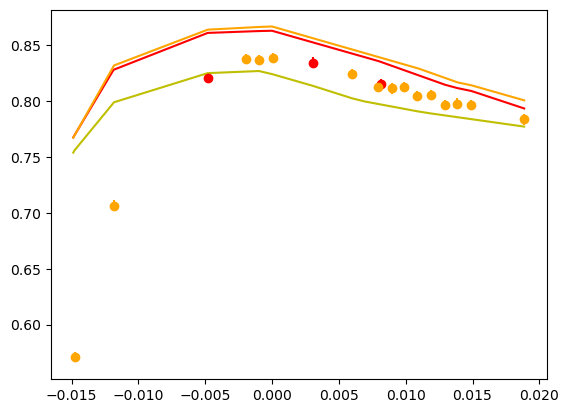

In [ ]:
# plot decodings
import os
from survey_agnostic_sn_vae.preprocessing import prep_input
import matplotlib.pyplot as plt
import numpy as np
import torch
from survey_agnostic_sn_vae.archival.raenn import *

LCFILE = 'superraenn/yse/lcs_merged.npz'
OUTFILE = 'superraenn/yse/outputs/out.npz'
OUTDIR = 'superraenn/yse'
PREPFILE = 'superraenn/prep.npz'

sequence, outseq, loss_mask, meta_dict = prep_input(
    LCFILE, load=True, outdir=OUTDIR, prep_file=PREPFILE
)
device = 'cpu'
model_fn = os.path.join(OUTDIR, "models_contrastive/model.pt")
model = torch.load(model_fn).to(device)
model.device = device
model.maxlen = sequence.shape[1]

dataset = SNDataset(sequence[:,:,:-1], outseq, sequence[:,0,-1], loss_mask, device=device)
model.save_outputs(
    dataset, meta=meta_dict, outdir=OUTDIR
)

out = np.load(OUTFILE, allow_pickle=True)
for k in out.files:
    print(k)
decodings = out['decodings']
z_means = out['z_means']
z_logvars = out['z_logvars']
ids2 = out['ids']
types = out['classes']

#assert(len(np.unique(ids)) == len(ids))
#assert(len(np.unique(ids2)) == len(ids2))
#assert np.all(ids == ids2)

for i in range(50):
    typ = types[i]
    dec = decodings[i]
    seq = sequence[i]
    loss_mask_x = loss_mask[i]
    z_mean = z_means[i:i+1]
    z_logvar = z_logvars[i:i+1]
    
    t = seq[:,0]
    f = seq[:,1:7]
    ferr = seq[:,7:13]
    amp = np.max(f) - np.min(f)

    colors = ['r','orange','y','g','b','purple']
    for b in range(6):
        mask = loss_mask_x[:,b].astype(bool)
        plt.errorbar(t[~mask], f[:,b][~mask], yerr=ferr[:,b][~mask], fmt='o', c=colors[b])
        plt.plot(t, dec[:,b], c=colors[b])
        
        print(amp, np.min(ferr[:,b][~mask]), np.max(ferr[:,b][~mask]))
        
    l = loss_function(
        torch.from_numpy(seq[np.newaxis,:,:]),
        torch.from_numpy(dec[np.newaxis,:,:]),
        torch.from_numpy(loss_mask_x[np.newaxis,:,:]).bool(), 6,
        z_mean, z_logvar, None, None,
    )
    plt.title(f'{l}: {typ}')
    plt.xlim((np.min(t), np.max(t[t<0.2])))
    plt.show()

In [ ]:
# run classification on all Pan-STARRS samples
from survey_agnostic_sn_vae.classification import *
from superphot_plus.plotting.format_params import set_global_plot_formatting

set_global_plot_formatting()

OUTFILE = 'superraenn/yse/outputs/out.npz'
feats, feat_errs, y = get_data(
    OUTFILE,
    include_surveys=['YSE', 'joint', 'ZTF'],
    data_type='3way'
)
for t in np.unique(y):
    plt.scatter(feats[:,0][y == t], feats[:,1][y == t], s=2)
plt.show()

for t in np.unique(y):
    plt.scatter(feats[:,1][y == t], feats[:,2][y == t], s=2)
plt.show()

vanilla_rf(feats, feat_errs, y)
#vanilla_mlp(feats, feat_errs, y)

NameError: name 'survey_submask' is not defined